In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Baseline simulation

Simulate the baseline model dynamics to produce data on:

1. Autocorrelation returns
2. Autocorrelation abs returns
3. Excess Kurtosis
4. Volume / Volatility correlation
5. HFT Sharpe ratio 
6. Percentage trades by HFT 

In [2]:
NRUNS = 10

In [3]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 5,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 2,
    "fundamental_value": 10,
    "std_fundamental": 0.0001,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 4,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 1.8, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "horizon_min": 1,
    "horizon_max": 8,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 3,
    "total_hft_money": 2000,
    "hft_speed": 1,
}

## Baseline monte carlo simulations

In [5]:
hfms = []
lfts = []
obs = []
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    print('seed is ', seed)
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
    hfms.append(hft)
    lfts.append(lft)
    obs.append(ob)

seed is  0
9.997043500000002
9.998043500000001
9.9990435
9.998043500000001
9.9990435
0.00245838006723
0.0031467073747
0.0297834669274
0.0304717942349
0.00638345377674
0.011841833844
0.00938345377674
0.0135301611514
0.0123834537767
0.0186097717918
0.0186097717918
0.0237564791665
0.0226097717918
0.00627561554613
0.0163166535003
0.0173166535003
0.0151285918025
0.0191764882231
-0.0431330121187
-0.0260044203162
-0.0421330121187
-0.0391330121187
-0.0199565238956
-0.024535274916
-0.025535274916
-0.023535274916
-0.0130628224542
-0.0120628224542
-0.0110628224542
-0.0100628224542
-0.00906282245423
-0.0705573962288
-0.0695573962288
-0.0685573962288
-0.0231430614082
-0.0221430614082
-0.0162817421894
-0.0142817421894
-0.0152817421894
-0.0109883429389
-0.0109883429389
-0.00030936033683
-0.0113823537557
-0.0103823537557
-0.00938235375571
-0.00838235375572
-0.0123823537557
-0.0113823537557
-0.0103823537557
-0.00938235375571
-0.00838235375572
-0.0634932196356
-0.0624932196356
0.0700399486766
0.07103994

## Retrieve data

In [6]:
def organise_data(obs):
    window = 20
    close_price = []
    returns = []
    autocorr_returns = []
    autocorr_abs_returns = []
    returns_volatility = []
    volume = []
    fundamentals = []
    for ob in obs: # record
        # close price
        close_price.append(ob.tick_close_price)
        # returns
        r = pd.Series(np.array(ob.tick_close_price)).pct_change()
        returns.append(r)
        # autocorrelation returns
        ac_r = [r.autocorr(lag=lag) for lag in range(25)]
        autocorr_returns.append(ac_r)
        # autocorrelation absolute returns
        absolute_returns = pd.Series(r).abs()
        autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
        # volatility of returns
        roller_returns = r.rolling(window)
        returns_volatility.append(roller_returns.std(ddof=0))
        # volume
        volume.append([sum(volumes) for volumes in ob.transaction_volumes_history])
        # fundamentals 
        fundamentals.append(ob.fundamental)
    mc_prices = pd.DataFrame(close_price).transpose()
    mc_returns = pd.DataFrame(returns).transpose()
    mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
    mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
    mc_volatility = pd.DataFrame(returns_volatility).transpose()
    mc_volume = pd.DataFrame(volume).transpose()
    mc_fundamentals = pd.DataFrame(fundamentals).transpose()
    
    return mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals

In [7]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

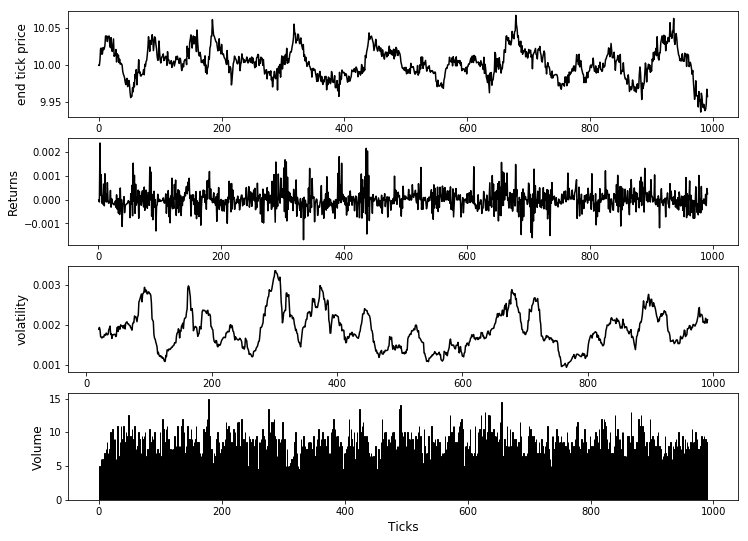

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
#ax1.legend()

ax2.plot(mc_returns.index, mc_returns.median(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(mc_volatility.index, mc_volatility.median(axis=1), 'k-')
ax3.set_ylabel('volatility', fontsize='12')

ax4.bar(mc_volume.index, mc_volume.median(axis=1), color='k', edgecolor='k')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Ticks', fontsize='12')

fig.savefig('hfm_baseline_dynamics.png')

# Stylized facts

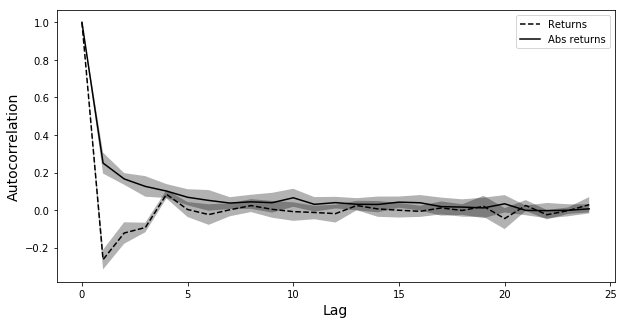

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('hfm_autocorrelation.png')

# Excess Kurtosis

In [10]:
kurt = []
for col in mc_prices:
    kurt.append(mc_prices[col].kurtosis())
np.mean(kurt)

1.4447674709403491

# Trades by HFT

In [11]:
def hft_in_match(match):
    for buy_sell in match:
        if 'HFT' in str(buy_sell):
            return True
    return False

In [12]:
def prcnt_hft_trading(ob):
    amount_matched_orders = 0
    hft_participating_orders = 0 
    for tick in ob.matched_bids_history:
        amount_matched_orders += len(tick)
        for match in tick:
            if hft_in_match(match):
                hft_participating_orders += 1
    
    percentage_hft_matches = hft_participating_orders / amount_matched_orders
    return percentage_hft_matches

In [13]:
percentage_trades_hfm = [prcnt_hft_trading(ob) for ob in obs]
percentage_trades_hfm

[0.5885264997087944,
 0.5808443423319931,
 0.6065855404438082,
 0.6105111591072714,
 0.5802378505358978,
 0.5999128666860296,
 0.5905752753977969,
 0.6068864468864469,
 0.5797818181818182,
 0.5753384343731607]

# HFT Profitability

In [14]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [15]:
def all_sharpe(hfts):
    money = []
    stocks = []
    locked_in_profits = []
    for hft in hfts:
        money.append(np.array(hft.var_previous.money))
        stocks.append(np.array(hft.var_previous.stocks))
        locked_in_profits.append(np.array(hft.var_previous.locked_profit))
    all_profits = np.concatenate(locked_in_profits)
    all_sharpe = sharpe(len(all_profits), all_profits.mean(), all_profits.std())
    return all_sharpe

In [16]:
all_s = [all_sharpe(h) for h in hfms]
np.mean(all_s)

0.86625176750397892

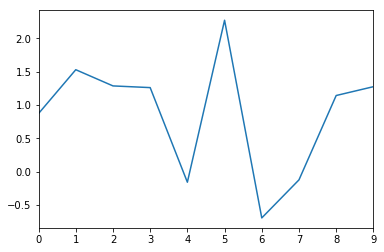

In [17]:
pd.Series(all_s).plot()